## Importing depandancies

In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import string
import emoji
from tqdm import tqdm

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/real-or-not-nlp-with-disaster-tweets-addings/train_add.csv
../input/glove-file/glove.6B.100d.txt
../input/nlp-getting-started/sample_submission.csv
../input/nlp-getting-started/train.csv
../input/nlp-getting-started/test.csv
../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
../input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt


In [52]:
!pip install pyspellchecker

^C
ERROR: Operation cancelled by user


In [53]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [54]:
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from spellchecker import SpellChecker
import gensim
from gensim.models.word2vec import Word2Vec

In [55]:
from sklearn import manifold
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.linear_model   import LogisticRegression
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from xgboost                import XGBClassifier
from lightgbm               import LGBMClassifier

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             f1_score,
                             recall_score,
                             precision_recall_fscore_support,
                             roc_auc_score)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [56]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from transformers import BertModel, BertConfig
import tokenization

In [57]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [58]:
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

In [59]:
train = pd.read_csv("../input/nlp-getting-started/train.csv")
train2 = pd.read_csv('../input/real-or-not-nlp-with-disaster-tweets-addings/train_add.csv')
test = pd.read_csv("../input/nlp-getting-started/test.csv")
submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")

In [60]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [61]:
lens = []
for sent in train['text'].str.split():
    lens.append(len(sent))
train['length'] = lens

In [62]:
train.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16


## Exploratory Data Analysis

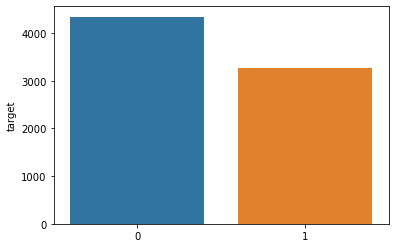

In [63]:
sns.barplot(train['target'].value_counts().index, train['target'].value_counts())

In [64]:
df1 = train.loc[train['target']==0]
df2 = train.loc[train['target']==1]

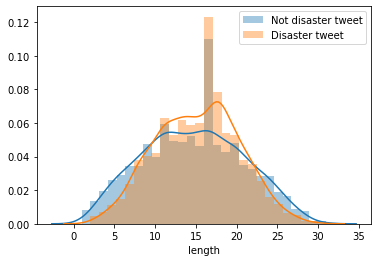

In [65]:
sns.distplot(df1['length'], label='Not disaster tweet')
sns.distplot(df2['length'], label='Disaster tweet')
plt.legend()

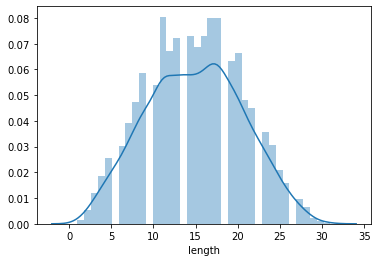

In [66]:
sns.distplot(train['length'])

In [67]:
text = df2['text'].values 

stopwords = set(STOPWORDS) 

wordcloud_truedis = WordCloud(max_words = 3000, width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(" ".join(df2.text))

In [68]:
text = df1['text'].values 
stopwords = set(STOPWORDS) 
wordcloud_falsedis = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(" ".join(df1.text))

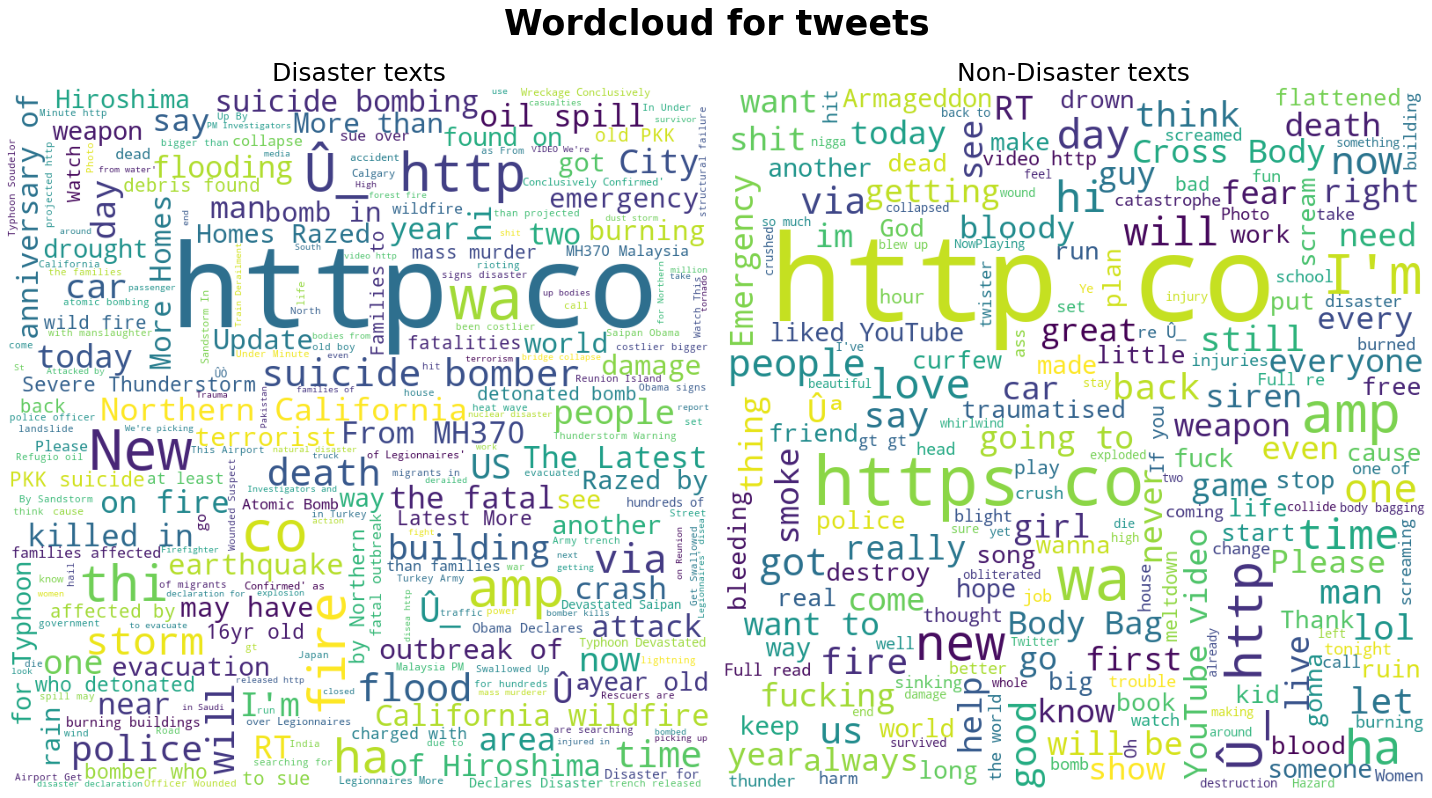

In [69]:
def plot_wordclouds(wordcloud_truedis, wordcloud_falsedis):
    plt.figure(figsize=(20,12.5))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_truedis)
    plt.title("Disaster texts", fontsize=25)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_falsedis)
    plt.title("Non-Disaster texts", fontsize=25)
    plt.axis("off")
    plt.tight_layout()
    plt.suptitle("Wordcloud for tweets", size=35,fontweight='bold')
    plt.show()
    
plot_wordclouds(wordcloud_truedis, wordcloud_falsedis)

In [70]:
ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
train.at[train['id'].isin(ids_with_target_error),'target'] = 0

In [71]:
train.groupby(['target'],as_index=False).count()

,target,id,keyword,location,text,length
0,0,4358,4339,2894,4358,4358
1,1,3255,3213,2186,3255,3255


Text(0.5, 0.98, 'Average word length in each tweet')

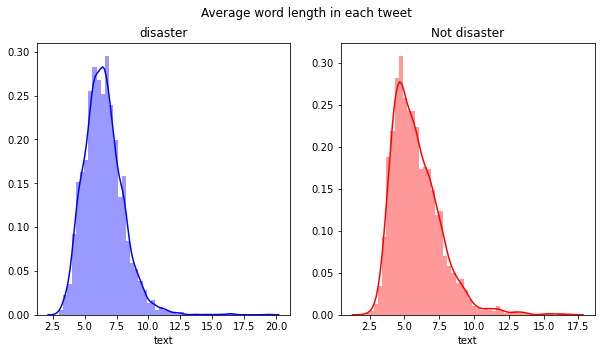

In [72]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

## Pre-processing

In [73]:
tweets = pd.concat([train,test])

In [74]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [75]:
nltk.download('punkt')
from nltk.corpus import stopwords
stop_wds = stopwords.words('english')

lemmatizer = WordNetLemmatizer() 
s = SnowballStemmer('english')
spell = SpellChecker()

def clean_text(text):
    text = re.sub('&amp',' and',text)
    text = re.sub('gt','greater than',text)
    text = re.sub('lt','lesser than',text)
    text = re.sub('n\'t',' not',text)
    text = re.sub('\'s',' is',text)
    text = re.sub('\'ll', 'will',text)
    text = re.sub('\'ve','have',text)
    text = re.sub('i\'m','i am',text)
    text = re.sub('\'re',' are',text)
    """text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #text = re.sub('\w*\d\w*','', text)"""
    return text

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

#for removing odd spaces and tokenize
def remove_spaces(text):
    text = text.lower()
    text = text.strip().split()
    text = " ".join(text)
    return text

#stemming the words
lemmatizer = WordNetLemmatizer() 
s = SnowballStemmer('english')
def stemm(text):
    l=[]
    text = word_tokenize(text)
    for word in text:
        if word not in stop_wds:
            #worded = lemmatizer.lemmatize(word)
            #worded = s.stem(worded)
            l.append(word)
    return " ".join(l)

#for taking care of emojis

emojis = emoji.UNICODE_EMOJI

#cleaning
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    
    x = re.findall(url, text)
    if x!=[]:
        x = x[0]
    else : 
        x = ''
    return text.replace(x,'')

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def convert_abbrev(word):
    sent=[]
    for words in word.split(" "):
        
        if words.lower() in abbreviations.keys():
            sent.append(abbreviations[words.lower()])
        else :
            sent.append(words)
    return(sent)
                         

tweets['new_text']=tweets['text'].apply(lambda x: clean_text(x))
tweets['new_text']=tweets['new_text'].apply(lambda x: remove_URL(x))
tweets['new_text']=tweets['new_text'].apply(lambda x: remove_spaces(x))
tweets['new_text']=tweets['new_text'].apply(lambda x: remove_punct(x))
tweets['new_text']=tweets['new_text'].apply(lambda x: remove_html(x))
tweets['new_text']=tweets['new_text'].apply(lambda x: convert_abbrev(x))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [76]:
train = tweets[:train.shape[0]]
test = tweets[train.shape[0]:]

## EDA Post pre-processing

In [77]:
def join_texts(text_list):
    return " ".join(text_list)
z=[]
for el in train['new_text']:
    z.append(join_texts(el))
    
train['new_text_joint'] = z

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Text(0.5, 0.98, 'Average word length in each tweet after processing')

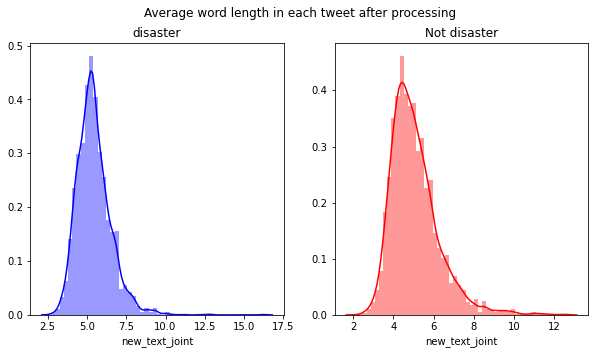

In [78]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['new_text_joint'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('disaster')
word=train[train['target']==0]['new_text_joint'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet after processing')

In [79]:
df1 = train.loc[train['target']==0]
df2 = train.loc[train['target']==1]

stopwords = set(STOPWORDS) 

wordcloud_truedis = WordCloud(max_words = 3000, width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(" ".join(df2['new_text_joint']))

In [80]:
wordcloud_falsedis = WordCloud(max_words = 3000, width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(" ".join(df1['new_text_joint']))

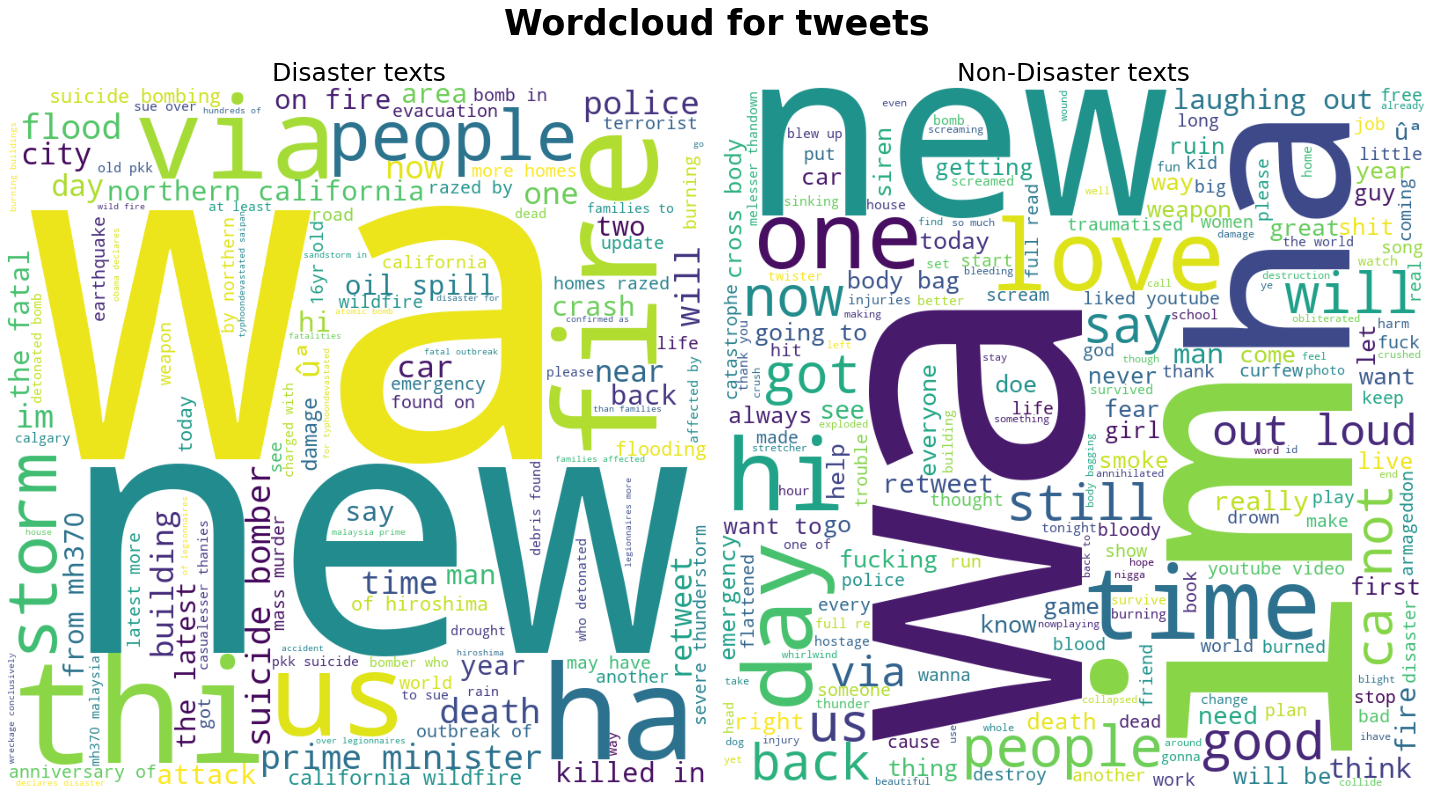

In [81]:
plot_wordclouds(wordcloud_truedis, wordcloud_falsedis)

## Vectorization

In [82]:
np.array(train['new_text'])

array([list(['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']),
       list(['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']),
       list(['all', 'residents', 'asked', 'to', 'ishelesser', 'thaner', 'in', 'place', 'are', 'being', 'notified', 'by', 'officers', 'no', 'other', 'evacuation', 'or', 'shelesser', 'thaner', 'in', 'place', 'orders', 'are', 'expected']),
       ...,
       list(['m194', '0104', 'utc5km', 's', 'of', 'volcano', 'hawaii']),
       list(['police', 'investigating', 'after', 'an', 'ebike', 'collided', 'with', 'a', 'car', 'in', 'little', 'portugal', 'ebike', 'rider', 'suffered', 'serious', 'nonlife', 'threatening', 'injuries']),
       list(['the', 'latest', 'more', 'homes', 'razed', 'by', 'northern', 'california', 'wildfire', '', 'abc', 'news'])],
      dtype=object)

In [83]:
corpus = train['new_text']
nlp = gensim.models.word2vec.Word2Vec(corpus, size=200,   
            window=6, min_count=1, sg=1, iter=30)

nlp.most_similar("fire")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """


[('truck', 0.7194012999534607),
 ('township', 0.6208171248435974),
 ('lightningcaused', 0.6150643825531006),
 ('brush', 0.6126235127449036),
 ('catches', 0.6122040152549744),
 ('canontattoo', 0.6065040230751038),
 ('apartment', 0.5997216105461121),
 ('vocpetroleum', 0.5918907523155212),
 ('denton', 0.5904029011726379),
 ('httptcojqxm4gcqz3', 0.5884792804718018)]

In [84]:
nlp.train(np.array(train['new_text']), total_examples=10, epochs=100)
# vector

(9464133, 11144500)

In [85]:
vector = nlp.wv['fire']

In [86]:
vector

array([-7.8087425e-01,  2.7942869e-01,  8.5796052e-01, -1.8339461e-01,
        1.9195729e-01, -2.8977397e-01,  2.8406844e-01,  4.2172012e-01,
       -3.2578835e-01,  7.5634766e-01,  6.6985893e-01,  2.6058555e-01,
        6.5146530e-01,  4.8726776e-01, -1.4637175e-01,  2.5007761e-01,
        3.1222898e-01, -2.9656339e-01, -5.2237075e-02, -1.8680009e-01,
       -5.3922737e-01,  3.8222304e-01,  6.7257977e-01,  6.0631800e-01,
       -3.8479948e-01, -2.9819679e-01, -4.6898356e-01, -4.9827510e-01,
        7.9070870e-03, -2.5651479e-01, -5.6787950e-01, -3.1085941e-01,
        9.5821774e-01, -4.5270491e-01, -8.9530838e-01, -7.9564482e-01,
       -1.5415762e-01,  6.5405726e-01, -1.6509336e-01, -1.7241304e-01,
        4.7913080e-01,  2.6955662e-02, -9.7248948e-01, -4.9567011e-01,
        1.6796586e-01,  2.0409848e-01, -4.9443382e-01,  2.1860684e-01,
       -1.7058247e-01,  2.6451644e-01,  5.8543319e-01, -1.2219871e-03,
        6.7149651e-01, -6.3402808e-01,  3.9982316e-01, -7.4211127e-01,
      

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


<Figure size 432x288 with 0 Axes>

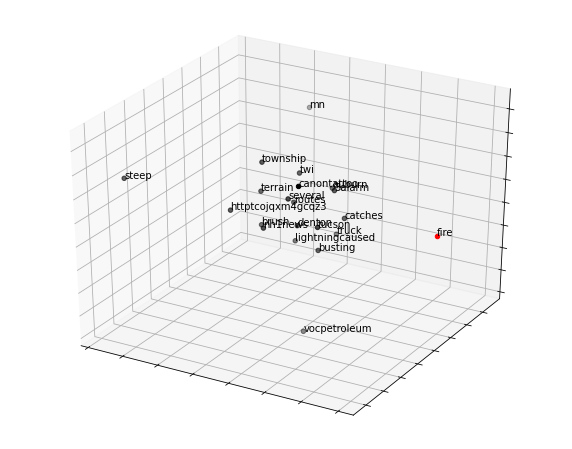

In [87]:
fig = plt.figure()
word = "fire"
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]

## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

## create data frame with 3 axis
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

# plot 3d
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)
plt.show()

In [88]:
# help(nlp)

## Modelling

In [89]:
X = train['new_text_joint']
y = train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [90]:
# !pip uninstall tensorflow
# !pip install tensorflow==1.15 --y


In [91]:
# import tensorflow as tf
# import tensorflow_hub as hub

# embed = hub.Module('https://tfhub.dev/google/elmo/3', trainable=True)

# embeddings = embed(
#     np.array(train["text"]),
#     signature="default",
#     as_dict=True)["default"]

In [92]:
# x = ["Roasted ants are a popular snack in Columbia"]

# # Extract ELMo features 
# embeddings = elmo(x, signature="default", as_dict=True)["elmo"]

In [93]:
tfidf = TfidfVectorizer(lowercase=False, stop_words='english', preprocessor=None)
X_tfidf_train = tfidf.fit_transform(X_train)
X_tfidf_test = tfidf.transform(X_test)

# print(X_tfidf_train.shape)
# print(y_train.shape)

# logit = LogisticRegression(random_state=0)
# param = {'C': [0.1, 1, 2, 3],
#         'solver': ['lbfgs', 'liblinear']}
# logit_grid = GridSearchCV(estimator = logit, param_grid = param, 
#                           scoring = 'f1', n_jobs = -1,)
# logit_grid.fit(X_tfidf_train, y_train)
# logit_grid.best_params_

# logit.fit(X_tfidf_train, y_train)

# y_pred = logit.predict(X_tfidf_test)
# print('F1 = ', f1_score(y_true = y_test, y_pred = y_pred))
# print('Accuracy = ', precision_score(y_true = y_test, y_pred = y_pred))

In [94]:
logit = LogisticRegression(C = 4, solver = 'lbfgs',random_state=0)
dt = DecisionTreeClassifier(criterion='gini', max_depth=200, random_state=0)
rf = RandomForestClassifier(max_depth=200, n_estimators=300, random_state=0, n_jobs=-1)
extr = ExtraTreesClassifier(n_estimators=200, max_depth=300, random_state=0, n_jobs=-1)
xgb = XGBClassifier(n_estimators=100, max_depth=20)
lgb = LGBMClassifier(random_state=0)
mlp = MLPClassifier(random_state=1, max_iter=300)

def get_acc(model, X_train, y_train, X_test, cv):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_true = y_test, y_pred = y_pred)
    prec = precision_score(y_true = y_test, y_pred = y_pred)
    rec = recall_score(y_pred, y_test)
    acc = accuracy_score(y_pred, y_test)
    roc = roc_auc_score(y_test, y_pred)
#     cv_sc = cross_val_score(model, X_train, y_train, cv=cv).mean()
    print("F1 Score : ", f1)
    print("Precision : ", prec)
    print("Reall : ", rec)
    print("Accuracy : ", acc)
    print("ROC : ", roc)
#     print("Cross Validated Score : ", cv_sc)
    return f1, prec, rec, acc, roc

In [95]:
models = [logit, dt, rf, extr, xgb, lgb, mlp]
xs = ['F1 Score', 'Precision', 'Recall', 'Accuracy', 'ROC']
model_names = ['Logistic Regression', 'Decision tree', 'Random Forest', 'Extra Tress Classifier', 'XGBoost Classifier', 'LightGBM Classifier','Multi layer perceptron']
def get_acc_df(xs,model_names,accs):
    df = pd.DataFrame(data=accs,columns=xs)
    df['model_names'] = model_names
    return df

In [96]:
from tqdm import tqdm
accs=[]
for model in tqdm(models) : 
    f1, prec, rec, acc, roc = get_acc(model, X_tfidf_train, y_train, X_tfidf_test, 10)
    accs.append([f1, prec, rec, acc, roc])

 14%|█▍        | 1/7 [00:00<00:01,  4.59it/s]

F1 Score :  0.7392
Precision :  0.7725752508361204
Reall :  0.7725752508361204
Accuracy :  0.7860892388451444
ROC :  0.7763128271514607


 29%|██▊       | 2/7 [00:01<00:02,  2.18it/s]

F1 Score :  0.7183544303797469
Precision :  0.7418300653594772
Reall :  0.7418300653594772
Accuracy :  0.7664041994750657
ROC :  0.7575631789272247


 43%|████▎     | 3/7 [00:12<00:15,  3.76s/it]

F1 Score :  0.736283185840708
Precision :  0.8702928870292888
Reall :  0.8702928870292888
Accuracy :  0.8044619422572179
ROC :  0.783467946192379


 57%|█████▋    | 4/7 [00:28<00:22,  7.42s/it]

F1 Score :  0.7474048442906575
Precision :  0.8571428571428571
Reall :  0.8571428571428571
Accuracy :  0.8083989501312336
ROC :  0.7900039398885575


 71%|███████▏  | 5/7 [00:35<00:14,  7.19s/it]

F1 Score :  0.7450331125827814
Precision :  0.8093525179856115
Reall :  0.8093525179856115
Accuracy :  0.7979002624671916
ROC :  0.7843122080261158


 86%|████████▌ | 6/7 [00:36<00:05,  5.36s/it]

F1 Score :  0.7296849087893864
Precision :  0.7942238267148014
Reall :  0.7942238267148014
Accuracy :  0.7860892388451444
ROC :  0.7720563404063714


100%|██████████| 7/7 [02:10<00:00, 18.66s/it]

F1 Score :  0.7200000000000001
Precision :  0.7222222222222222
Reall :  0.7222222222222222
Accuracy :  0.7611548556430446
ROC :  0.7556846963471604


In [97]:
df = get_acc_df(xs,model_names,accs)
df

,F1 Score,Precision,Recall,Accuracy,ROC,model_names
0,0.739200,0.772575,0.772575,0.786089,0.776313,Logistic Regression
1,0.718354,0.741830,0.741830,0.766404,0.757563,Decision tree
2,0.736283,0.870293,0.870293,0.804462,0.783468,Random Forest
3,0.747405,0.857143,0.857143,0.808399,0.790004,Extra Tress Classifier
4,0.745033,0.809353,0.809353,0.797900,0.784312,XGBoost Classifier
5,0.729685,0.794224,0.794224,0.786089,0.772056,LightGBM Classifier
6,0.720000,0.722222,0.722222,0.761155,0.755685,Multi layer perceptron


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

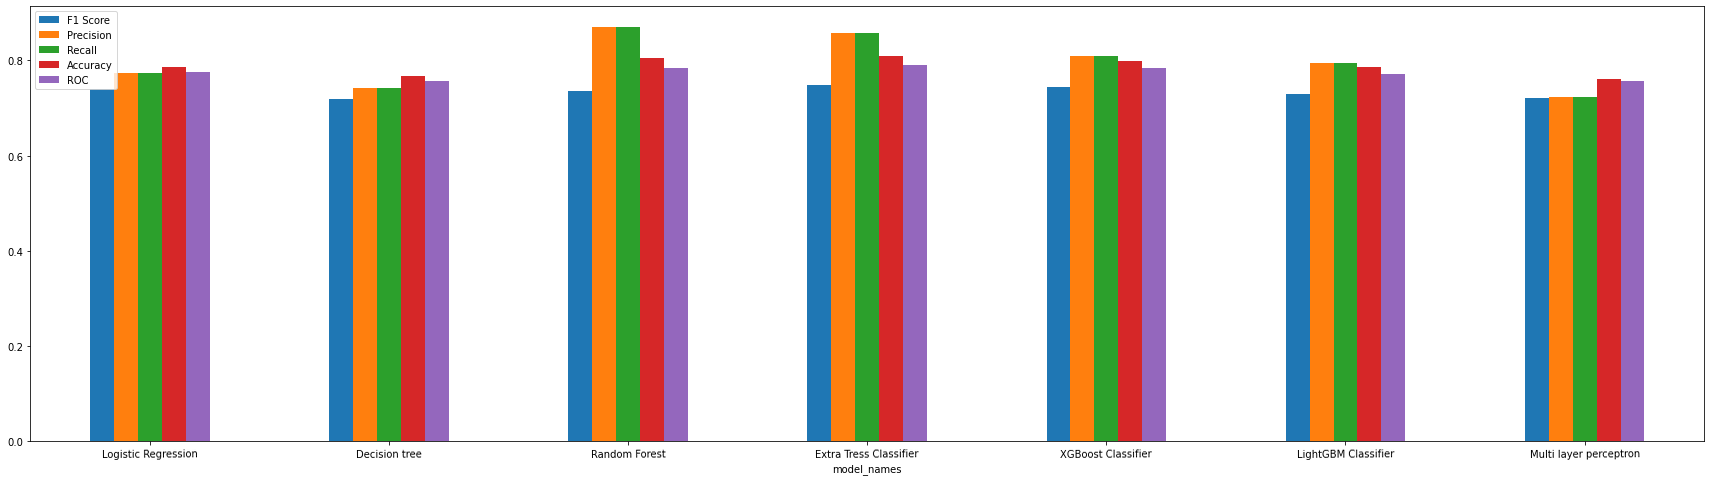

In [98]:
# plot figure
df.plot(x="model_names", y=xs, kind="bar", figsize=(30,8))
plt.xticks(rotation=0.4)

In [99]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding

tweet_1 = train.new_text_joint.values
sentiments = train.target.values

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(tweet_1)
vocab_length = len(word_tokenizer.word_index) + 1
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(tweet_1, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(tweet_1), length_long_sentence, padding='post')
# test_sentences = pad_sequences(
#     embed(test_1), 
#     length_long_sentence,
#     padding='post'
# )

embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('../input/glove-file/glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

X_train, X_test, y_train, y_test = train_test_split(
    padded_sentences, 
    sentiments, 
    test_size=0.25
)

In [100]:
def BLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [101]:
model = BLSTM()
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
#     validation_data = [X_test, y_test],
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
179/179 [==============================] - 43s 242ms/step - loss: 0.7407 - accuracy: 0.5905 - lr: 0.0010
Epoch 2/7
179/179 [==============================] - 43s 241ms/step - loss: 0.5672 - accuracy: 0.7092 - lr: 0.0010
Epoch 3/7
179/179 [==============================] - 43s 241ms/step - loss: 0.4966 - accuracy: 0.7791 - lr: 0.0010
Epoch 4/7
179/179 [==============================] - 43s 242ms/step - loss: 0.4485 - accuracy: 0.8129 - lr: 0.0010
Epoch 5/7
179/179 [==============================] - 43s 240ms/step - loss: 0.3975 - accuracy: 0.8397 - lr: 0.0010
Epoch 6/7
179/179 [==============================] - 42s 235ms/step - loss: 0.3495 - accuracy: 0.8574 - lr: 0.0010
Epoch 7/7
179/179 [==============================] - 43s 243ms/step - loss: 0.2869 - accuracy: 0.8968 - lr: 0.0010


In [102]:
y_pred = model.predict_classes(X_test)
precision_score(y_true = y_test, y_pred = y_pred)

0.8429172510518934

In [103]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 100)           1873300   
_________________________________________________________________
bidirectional (Bidirectional (None, 35, 70)            38080     
_________________________________________________________________
global_max_pooling1d (Global (None, 70)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 70)                280       
_________________________________________________________________
dropout (Dropout)            (None, 70)                0         
_________________________________________________________________
dense (Dense)                (None, 35)                2485      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0

In [104]:
def get_acc(models, X_test):
    for model in models:
        y_pred = model.predict(X_test)
        f1 = f1_score(y_true = y_test, y_pred = y_pred)
        acc = precision_score(y_true = y_test, y_pred = y_pred)
    return f1,acc

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)

In [105]:
y_pred = model.predict_classes(X_test)
precision_score(y_true = y_test, y_pred = y_pred)
metrics(y_pred, y_test)

F1-score:  0.7795071335927367
Precision:  0.7249698431845597
Recall:  0.8429172510518934
Acuracy:  0.8214285714285714
--------------------------------------------------


In [106]:
# !pip install tensorflow

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [107]:
def BLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2))
    model.add(LSTM(1024, return_sequences = True))
    model.add(LSTM(512, return_sequences = True))
    model.add(LSTM(256, return_sequences = True))
    model.add(LSTM(128, return_sequences = True))
    model.add(LSTM(64, return_sequences = True))
    model.add(LSTM(64, return_sequences = True))
    model.add(LSTM(64, return_sequences = True))
    model.add(LSTM(128, return_sequences = True))
    model.add(LSTM(256, return_sequences = True))
    model.add(LSTM(512, return_sequences = True))
    model.add(LSTM(1024, return_sequences = True))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = BLSTM()
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
#     validation_data = [X_test, y_test],
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
179/179 [==============================] - 31s 172ms/step - loss: 0.6158 - accuracy: 0.6793 - lr: 0.0010
Epoch 2/7
179/179 [==============================] - 30s 170ms/step - loss: 0.5044 - accuracy: 0.7930 - lr: 0.0010
Epoch 3/7
 25/179 [===>..........................] - ETA: 25s - loss: 0.4582 - accuracy: 0.8138

KeyboardInterrupt: 

In [108]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

#inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
#outputs = model(**inputs)

#last_hidden_states = outputs[0]

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [109]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [110]:
module_url = "https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/2"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [111]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [112]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [113]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [114]:
del(tweets)

In [115]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=16*strategy.num_replicas_in_sync
)

Epoch 1/3
381/381 [==============================] - 430s 1s/step - loss: 0.4401 - accuracy: 0.8099 - val_loss: 0.3791 - val_accuracy: 0.8444
Epoch 2/3
381/381 [==============================] - 394s 1s/step - loss: 0.3195 - accuracy: 0.8722 - val_loss: 0.3824 - val_accuracy: 0.8477
Epoch 3/3
381/381 [==============================] - 394s 1s/step - loss: 0.2223 - accuracy: 0.9182 - val_loss: 0.4350 - val_accuracy: 0.8299


In [124]:
# model.load_weights('model.h5')
test_pred = model.predict(train_input)

In [126]:
test_pred[0]

array([0.84232587], dtype=float32)

In [127]:
y_pred=[]
for pred in test_pred:
    if pred>0.6 : 
        y_pred.append(1)
    else :
        y_pred.append(0)

In [129]:
np.array(y_pred)

array([1, 1, 1, ..., 1, 1, 1])

In [130]:
# y_pred = model.predict(X_test)
precision_score(y_true = train_labels, y_pred = np.array(y_pred))
metrics(np.array(y_pred), train_labels)

F1-score:  0.8040418621436305
Precision:  0.6844854070660522
Recall:  0.9742020113686052
Acuracy:  0.8573492709838434
--------------------------------------------------


In [ ]:
test_pred

In [ ]:
submission['target'] = test_pred
submission.to_csv('submission.csv', index=False)

In [ ]:
submission.groupby(['target']).count()

module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)
model2 = build_model(bert_layer, max_len=160)
model2.summary()

checkpoint = ModelCheckpoint('model2.h5', monitor='val_loss', save_best_only=True)

train_history = model2.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=16
)

module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)
model2 = build_model(bert_layer, max_len=160)
model2.summary()

checkpoint = ModelCheckpoint('model2.h5', monitor='val_loss', save_best_only=True)

train_history = model2.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=16
)

model2.load_weights('model2.h5')
test_pred2 = model.predict(test_input)

module_url = "https://tfhub.dev/tensorflow/albert_en_xxlarge/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)
model3 = build_model(bert_layer, max_len=160)
model3.summary()

checkpoint = ModelCheckpoint('model3.h5', monitor='val_loss', save_best_only=True)

train_history = model3.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=16
)

model3.load_weights('model2.h5')
test_pred3 = model.predict(test_input)

import numpy as np

test_pred = (np.array(test_pred)+np.array(test_pred2)+np.array(test_pred3))/3

submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)